# Spherical harmonic normalizations and Parseval's theorem

## The variance of a single spherical harmonic

We will here demonstrate the relatioship between a function expressed in spherical harmonics and its variance. To make things simple, we will consider only a single harmonic, and note that the results are easily extended to more complicated functions given that the spherical harmonics are orthogonal. 

We start by initializing a new coefficient class to zero and setting a single coefficient to 1.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pyshtools

In [2]:
pyshtools.utils.figstyle(rel_width=0.75)
%config InlineBackend.figure_format = 'retina'  # if you are not using a retina display, comment this line

In [3]:
lmax = 100
coeffs = pyshtools.SHCoeffs.from_zeros(lmax)
coeffs.set_coeffs(values=[1], ls=[5], ms=[2])

Given that we will perform some numerical integrations with this function below, we expand it onto a grid appropriate for integration by Gauss-Legendre quadrature:

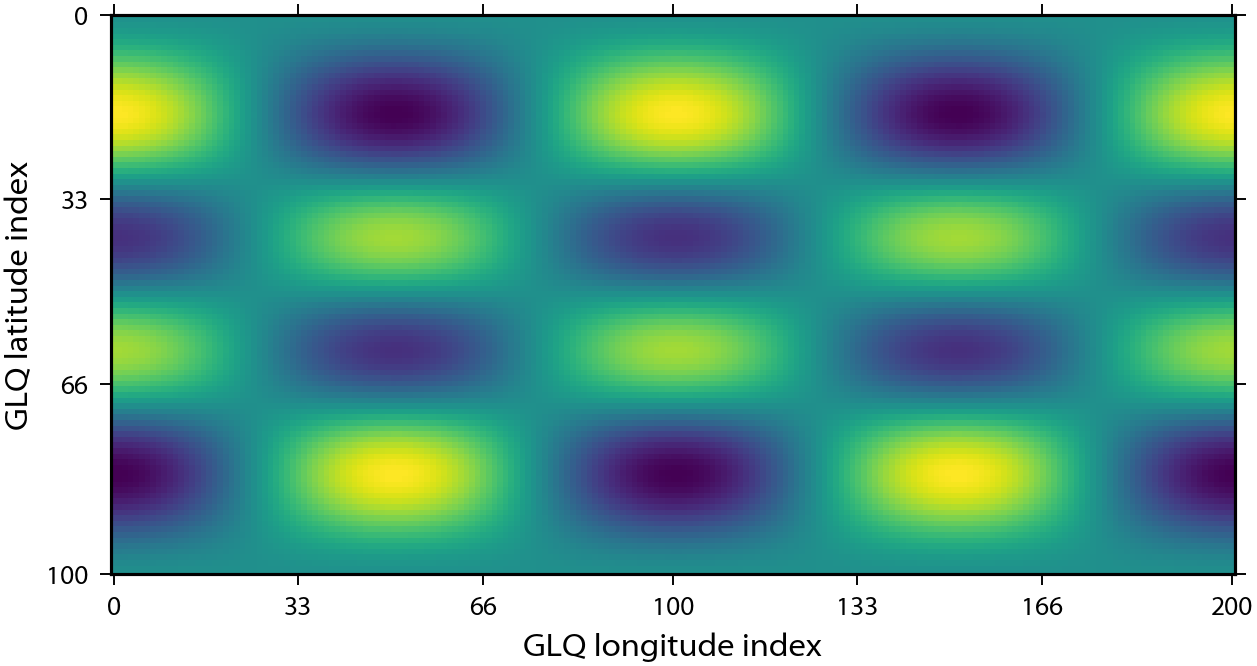

In [4]:
grid = coeffs.expand(grid='GLQ')
fig, ax = grid.plot(show=False)    # show=False is used to avoid a warning when plotting in inline mode

Next, we would like to calculate the variance of this single spherical harmonic. Since each spherical harmonic has a zero mean, the variance is equal to the integral of the function squared (i.e., its norm $N_{lm}$) divided by the surface area of the sphere ($4\pi$): 

$$N_{lm} = \int_\Omega Y^2_{lm}(\mathbf{\theta, \phi})~d\Omega$$
$$Var(Y_{lm}) = \frac{N_{lm}}{4 \pi}$$

When the spherical harmonics are $4\pi$ normalized, $N_{lm}$ is equal to $4\pi$ for all values of `l` and `m`. Thus, by definition, the variance of each harmonic is 1 for $4\pi$-nomalized harmonics.

We can verify the mathematical value of $N_{lm}$ by doing the integration manually. For this, we will perform a Gauss-Legendre Quadrature, making use of the latitudinal weighting function that is stored in the `SHGrid` class instance.

In [5]:
N = ((grid.data**2) * grid.weights[np.newaxis,:].T).sum() * (2. * np.pi / grid.nlon)

print('N = ', N)
print('Variance of Ylm = ', N / (4. * np.pi))

N =  12.56637061435917
Variance of Ylm =  0.9999999999999999


Alternatively, we could have done the integration with a 'DH' grid instead:

In [6]:
grid_dh = coeffs.expand(grid='DH')
weights = pyshtools.utils.DHaj(grid_dh.nlat)

N = ((grid_dh.data**2) * weights[np.newaxis,:].T).sum() * 2. * np.sqrt(2.) * np.pi / grid_dh.nlon

print('N = ', N)
print('Variance of Ylm = ', N / (4. * np.pi))

N =  12.566370614359174
Variance of Ylm =  1.0000000000000002


## Parseval's theorem

We have seen in the previous section that a single $4\pi$-normalized spherical harmonic has unit variance. In spectral analysis, the word *power* is often used to mean the value of the function squared divided by the area it spans, and if the function has zero mean, power is equivalent to variance. Since the spherical harmonics are orthogonal functions on the sphere, there exists a simple relationship between the power of the function and its spherical harmonic coefficients:

$$\frac{1}{4 \pi} \int_{\Omega} f^2(\mathbf{\theta, \phi})~d\Omega = \sum_{lm} C_{lm}^2 \frac{N_{lm}}{4 \pi}$$

This is Parseval's theorem for data on the sphere. For $4\pi$ normalized harmonics, the last fraction on the right hand side is unity, and the total variance (power) of the function is the sum of the coefficients squared. Knowning this, we can confirm the result of the previous section by showing that the total power of the `l=5`, `m=2` harmonic is unity:

In [7]:
power = coeffs.spectrum()
print('Total power is ', power.sum())

Total power is  1.0
